In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)



In [9]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

In [5]:
sns.set_style("white")
rs = np.random.RandomState(5)

initial = rs.normal(size = 100)
new = rs.normal(loc = 0.2, size = 120)

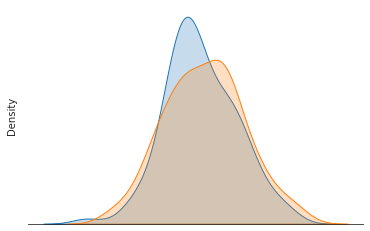

In [6]:
plot = sns.kdeplot(initial, shade=True)
plot = sns.kdeplot(new, shade=True)
plot.set(yticklabels=[], xticklabels = [])
sns.despine(left=True)

In [10]:
buckets = 10
raw_breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
breakpoints = scale_range(raw_breakpoints, np.min(initial), np.max(initial))

In [11]:
initial_counts = np.histogram(initial, breakpoints)[0]
new_counts = np.histogram(new, breakpoints)[0]

In [12]:
df = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':initial_counts, 'New Count':new_counts})
df['Initial Percent'] = df['Initial Count'] / len(initial)
df['New Percent'] = df['New Count'] / len(new)

In [14]:
df['New Percent'][df['New Percent'] == 0] = 0.001


<ipython-input-14-6e6051a78abf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['New Percent'][df['New Percent'] == 0] = 0.001


In [15]:
df

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent
0,1,-2.330642,1,0,0.01,0.001000
1,2,-1.801596,1,3,0.01,0.025000
2,3,-1.272550,4,6,0.04,0.050000
3,4,-0.743504,8,15,0.08,0.125000
4,5,-0.214458,27,18,0.27,0.150000
5,6,0.314588,22,23,0.22,0.191667
6,7,0.843633,16,26,0.16,0.216667
7,8,1.372679,12,14,0.12,0.116667
8,9,1.901725,6,9,0.06,0.075000
9,10,2.430771,3,3,0.03,0.025000


In [16]:
percents = df[['Initial Percent', 'New Percent', 'Bucket']] \
             .melt(id_vars=['Bucket']) \
             .rename(columns={'variable':'Population', 'value':'Percent'})

In [17]:
percents.head()


,Bucket,Population,Percent
0,1,Initial Percent,0.01
1,2,Initial Percent,0.01
2,3,Initial Percent,0.04
3,4,Initial Percent,0.08
4,5,Initial Percent,0.27


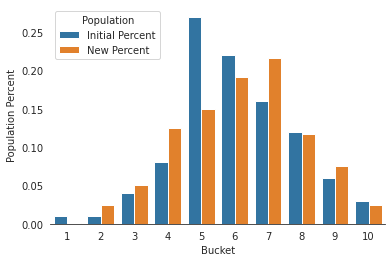

In [18]:

p = sns.barplot(x="Bucket", y="Percent", hue="Population", data=percents)
p.set(xlabel='Bucket', ylabel='Population Percent')
sns.despine(left=True)

In [21]:
df['PSI'] = (df['New Percent'] - df['Initial Percent']) * np.log(df['New Percent'] / df['Initial Percent'])


In [22]:
df.head()

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent,PSI
0,1,-2.330642,1,0,0.01,0.001,0.020723
1,2,-1.801596,1,3,0.01,0.025,0.013744
2,3,-1.272550,4,6,0.04,0.050,0.002231
3,4,-0.743504,8,15,0.08,0.125,0.020083
4,5,-0.214458,27,18,0.27,0.150,0.070534
